## Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist). Meaning we can get started straight away.

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

> 📖 **Resource:** The following multiclass classification problem has been adapted from the [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

In [ ]:
#import libraries 
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Now let's check out an example.

In [ ]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n") 
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

Woah, we get a large list of numbers, followed (the data) by a single number (the class label).

What about the shapes?

In [ ]:
# Check the shape of our data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# Check shape of a single example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

Okay, 60,000 training examples each with shape (28, 28) and a label each as well as 10,000 test examples of shape (28, 28).

But these are just numbers, let's visualize.

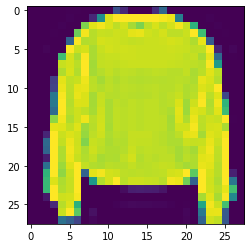

In [ ]:
# Plot a single example
plt.imshow(train_data[7]);

Hmm, but what about its label?

In [ ]:
# Check our samples label
train_labels[7]

2

It looks like our labels are in numerical form. And while this is fine for a neural network, you might want to have them in human readable form.

Let's create a small list of the class names (we can find them on [the dataset's GitHub page](https://github.com/zalandoresearch/fashion-mnist#labels)).

> 🔑 **Note:** Whilst this dataset has been prepared for us and ready to go, it's important to remember many datasets won't be ready to go like this one. Often you'll have to do a few preprocessing steps to have it ready to use with a neural network (we'll see more of this when we work with our own data later).

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10

Now we have these, let's plot another example.

> 🤔 **Question:** Pay particular attention to what the data we're working with *looks* like. Is it only straight lines? Or does it have non-straight lines as well? Do you think if we wanted to find patterns in the photos of clothes (which are actually collections of pixels), will our model need non-linearities (non-straight lines) or not?

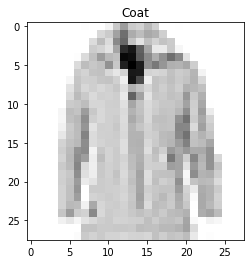

In [ ]:
# Plot an example image and its label
index = 19
plt.imshow(train_data[index], cmap=plt.cm.binary) # change the colours to black & white
plt.title(class_names[train_labels[index]]);

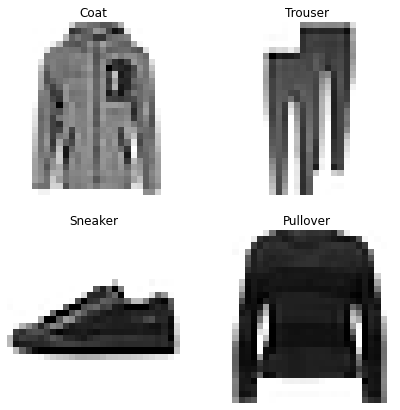

In [ ]:
# Plot multiple random images of fashion MNIST
import random
plt.figure(figsize=(7, 7))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  rand_index = random.choice(range(len(train_data)))
  plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
  plt.title(class_names[train_labels[rand_index]])
  plt.axis(False)

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function. 
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

You ready? Let's go.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784, the Flatten layer does this for us)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
non_norm_history = model_11.fit(train_data,
                                train_labels,
                                epochs=10,
                                validation_data=(test_data, test_labels)) # see how the model performs on the test set during training

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 2.1671 - accuracy: 0.1606 - val_loss: 1.7959 - val_accuracy: 0.2046
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7066 - accuracy: 0.2509 - val_loss: 1.6567 - val_accuracy: 0.2805
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6321 - accuracy: 0.2806 - val_loss: 1.6094 - val_accuracy: 0.2857
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.6052 - accuracy: 0.2833 - val_loss: 1.6041 - val_accuracy: 0.2859
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5975 - accuracy: 0.2862 - val_loss: 1.6064 - val_accuracy: 0.2756
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5950 - accuracy: 0.2920 - val_loss: 1.5747 - val_accuracy: 0.2994
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5775 - accuracy: 0.3040 - val_loss: 1.6030 - val_accuracy:

In [ ]:
# Check the shapes of our model
# Note: the "None" in (None, 784) is for batch_size, we'll cover this in a later module
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 4)                 3140      
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1? (if not, treat this as a reminder)

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized (hence why we used the `non_norm_history` variable when calling `fit()`). It's pixel values are between 0 and 255.

Let's see.

In [ ]:
# Check the min and max values of the training data
train_data.min(), train_data.max()

(0.0, 1.0)

We can get these values between 0 and 1 by dividing the entire array by the maximum: `255.0` (dividing by a float also converts to a float).


Doing so will result in all of our data being between 0 and 1 (known as **scaling** or **normalization**).

In [ ]:
# Divide train and test images by the maximum value (normalize it)
train_data = train_data / 255.0
test_data = test_data / 255.0

# Check the min and max values of the training data
train_data.min(), train_data.max()

(0.0, 1.0)

Beautiful! Now our data is between 0 and 1. Let's see what happens when we model it.

We'll use the same model as before (`model_11`) except this time the data will be normalized.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_12 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model (to the normalized data)
norm_history = model_12.fit(train_data,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data, test_labels))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6376 - accuracy: 0.7757 - val_loss: 0.6400 - val_accuracy: 0.7820
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5942 - accuracy: 0.7914 - val_loss: 0.6247 - val_accuracy: 0.7783
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5750 - accuracy: 0.7979 - val_loss: 0.6078 - val_accuracy: 0.7881
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5641 - accuracy: 0.8006 - val_loss: 0.6169 - val_accuracy: 0.7881
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5544 - accuracy: 0.8043 - val_loss: 0.5855 - val_accuracy: 0.7951
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5488 - accuracy: 0.8063 - val_loss: 0.6097 - val_accuracy:

Woah, we used the exact same model as before but we with normalized data we're now seeing a much higher accuracy value!

Let's plot each model's history (their loss curves).

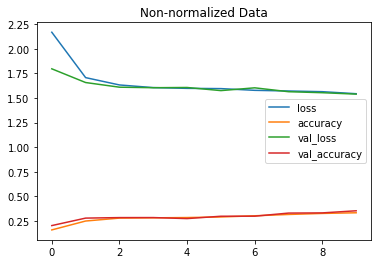

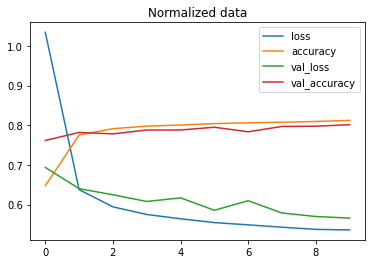

In [ ]:
# Plot non-normalized data loss curves
pd.DataFrame(non_norm_history.history).plot(title="Non-normalized Data")
# Plot normalized data loss curves
pd.DataFrame(norm_history.history).plot(title="Normalized data");

Wow. From these two plots, we can see how much quicker our model with the normalized data (`model_12`) improved than the model with the non-normalized data (`model_11`).

> 🔑 **Note:** The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).

How about we find the ideal learning rate and see what happens?

We'll use the same architecture we've been using.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_13 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_13.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
find_lr_history = model_13.fit(train_data,
                               train_labels,
                               epochs=40, # model already doing pretty good with current LR, probably don't need 100 epochs
                               validation_data=(test_data, test_labels),
                               callbacks=[lr_scheduler])

Epoch 1/40
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 2/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6366 - accuracy: 0.7759 - val_loss: 0.6400 - val_accuracy: 0.7808 - lr: 0.0011
Epoch 3/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5934 - accuracy: 0.7911 - val_loss: 0.6278 - val_accuracy: 0.7770 - lr: 0.0013
Epoch 4/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5749 - accuracy: 0.7969 - val_loss: 0.6122 - val_accuracy: 0.7871 - lr: 0.0014
Epoch 5/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5655 - accuracy: 0.7987 - val_loss: 0.6061 - val_accuracy: 0.7913 - lr: 0.0016
Epoch 6/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5569 - accuracy: 0.8022 - val_loss: 0.5917 - val_accuracy: 0.7940 - lr: 0.0018
Epoch 7/40
1875/1875 [==============================] - 4s

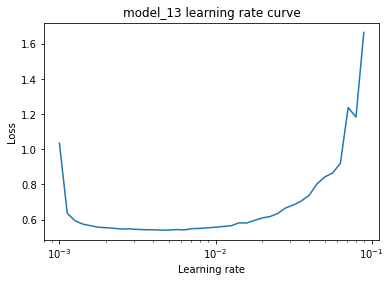

In [ ]:
# function to Plot the learning rate decay curve
def lr_cruve_plot(model, model_history):
  lrs = 1e-3 * (10**(np.arange(40)/20))
  plt.semilogx(lrs, find_lr_history.history["loss"]) # want the x-axis to be log-scale
  plt.xlabel("Learning rate")
  plt.ylabel("Loss")
  plt.title(model + " learning rate curve");

# Plot the learning rate decay curve
lr_cruve_plot("model_13", find_lr_history)

In this case, it looks like somewhere close to the default learning rate of the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) (`0.001`) is the ideal learning rate.

Let's refit a model using the ideal learning rate.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_14 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# Compile the model
model_14.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.001), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model_14.fit(train_data,
                       train_labels,
                       epochs=20,
                       validation_data=(test_data, test_labels))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1875/1875 [==============================] - 5s 2ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6376 - accuracy: 0.7757 - val_loss: 0.6400 - val_accuracy: 0.7820
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5942 - accuracy: 0.7914 - val_loss: 0.6247 - val_accuracy: 0.7783
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5750 - accuracy: 0.7979 - val_loss: 0.6078 - val_accuracy: 0.7881
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5641 - accuracy: 0.8006 - val_loss: 0.6169 - val_accuracy: 0.7881
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5544 - accuracy: 0.8043 - val_loss: 0.5855 - val_accuracy: 0.7951
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5488 - accuracy: 0.8063 - val_loss: 0.6097 - val_accuracy: 0.7836
Epo

Now we've got a model trained with a close-to-ideal learning rate and performing pretty well, we've got a couple of options.

We could:
* Evaluate its performance using other classification metrics (such as a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) or [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)).
* Assess some of its predictions (through visualizations).
* Improve its accuracy (by training it for longer or changing the architecture).
* Save and export it for use in an application.

Let's go through the first two options.

First we'll create a classification matrix to visualize its predictions across the different classes.

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb

# Our function needs a different name to sklearn's plot_confusion_matrix
 
def confusion_maxtrix_plot(model, y_true, y_preds, classes=None):

  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  
  import itertools
  from sklearn.metrics import confusion_matrix

  figsize = (10, 10)
  text_size = 15

  # Create the confusion matrix
  cm = confusion_matrix(y_true, tf.round(y_preds))
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
  fig.colorbar(cax)

  # Are there a list of classes?

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title= model + " Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  
  # Adjust label size
  #ax.xaxis.label.set_size(text_size)
  #ax.yaxis.label.set_size(text_size)
  #ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=7.3)

In [ ]:
# Make predictions with the most recent model
y_probs = model_14.predict(test_data) # "probs" is short for probabilities

# View the first 5 predictions
y_probs[:5]

array([[8.56299753e-11, 3.53615629e-13, 2.66337556e-05, 4.63562024e-08,
        5.09498605e-05, 9.61192474e-02, 8.17780403e-08, 9.18688551e-02,
        4.06052778e-03, 8.07873666e-01],
       [3.42785552e-06, 1.28992649e-16, 9.59891498e-01, 2.05162564e-07,
        1.53292371e-02, 2.45320095e-13, 2.41428725e-02, 1.13834485e-28,
        6.32718089e-04, 4.47896404e-08],
       [6.10630595e-05, 9.96576726e-01, 4.38669758e-08, 3.34058981e-03,
        1.32494861e-05, 1.43831603e-21, 8.27906115e-06, 7.32374630e-18,
        5.48116041e-08, 4.92251402e-14],
       [7.50314357e-05, 9.90536869e-01, 4.25285322e-07, 9.22318175e-03,
        1.36231421e-04, 1.82760903e-18, 2.68082422e-05, 4.81248308e-14,
        1.45215904e-06, 2.22114601e-11],
       [7.21899569e-02, 1.54957536e-06, 2.55668938e-01, 1.03631355e-02,
        4.35413495e-02, 1.10693023e-13, 6.16930187e-01, 6.75438989e-23,
        1.30491622e-03, 1.21404065e-09]], dtype=float32)

Our model outputs a list of **prediction probabilities**, meaning, it outputs a number for how likely it thinks a particular class is to be the label.

The higher the number in the prediction probabilities list, the more likely the model believes that is the right class.

To find the highest value we can use the [`argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method.

In [ ]:
# See the predicted class number and label for the first example
y_probs[0].argmax(), class_names[y_probs[0].argmax()]

(9, 'Ankle boot')

Now let's do the same for all of the predictions.

In [ ]:
# Convert all of the predictions from probabilities to labels
y_preds = y_probs.argmax(axis=1)

# View the first 10 prediction labels
y_preds[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

Wonderful, now we've got our model's predictions in label form, let's create a confusion matrix to view them against the truth labels.

In [ ]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_labels, 
                 y_pred=y_preds)

array([[696,   8,  25,  87,   9,   5, 160,   0,  10,   0],
       [  2, 939,   2,  35,   9,   0,  13,   0,   0,   0],
       [ 19,   2, 656,  10, 188,   0, 110,   0,  15,   0],
       [ 39,  10,  10, 819,  55,   0,  47,   1,  19,   0],
       [  0,   0,  95,  23, 800,   0,  73,   0,   7,   2],
       [  0,   0,   1,   0,   0, 894,   0,  60,   7,  38],
       [106,   4, 158,  57, 159,   1, 499,   0,  16,   0],
       [  0,   0,   0,   0,   0,  31,   0, 936,   0,  33],
       [  4,   1,  38,  15,   8,  12,   9,   5, 906,   2],
       [  0,   0,   1,   0,   2,  15,   0,  51,   1, 930]])

That confusion matrix is hard to comprehend, let's make it prettier using the function we created before.

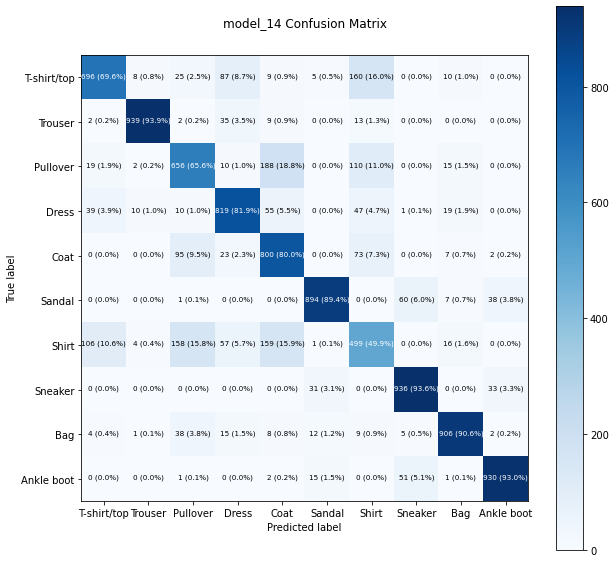

In [ ]:
# Make a prettier confusion matrix
confusion_maxtrix_plot("model_14", test_labels, y_preds, class_names)

That looks much better! (one of my favourites sights in the world is a confusion matrix with dark squares down the diagonal)

Except the results aren't as good as they could be...

It looks like our model is getting confused between the `Shirt` and `T-shirt/top` classes (e.g. predicting `Shirt` when it's actually a `T-shirt/top`).

> 🤔 **Question:** Does it make sense that our model is getting confused between the `Shirt` and `T-shirt/top` classes? Why do you think this might be? What's one way you could investigate?

We've seen how our models predictions line up to the truth labels using a confusion matrix, but how about we visualize some?

Let's create a function to plot a random image along with its prediction.

> 🔑 **Note:** Often when working with images and other forms of visual data, it's a good idea to visualize as much as possible to develop a further understanding of the data and the outputs of your model.

In [ ]:
# Create a function for plotting a random image along with its prediction
def plot_random_image(model, images, true_labels, classes):
  """Picks a random image, plots it and labels it with a predicted and truth label.

  Args:
    model: a trained model (trained on data similar to what's in images).
    images: a set of random images (in tensor form).
    true_labels: array of ground truth labels for images.
    classes: array of class names for images.
  
  Returns:
    A plot of a random image from `images` with a predicted class label from `model`
    as well as the truth class label from `true_labels`.
  """ 
  import random

  # Setup random integer
  i = random.randint(0, len(images))
  
  # Create predictions and targets
  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1, 28, 28)) # have to reshape to get into right size for model
  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]

  # Plot the target image
  plt.imshow(target_image, cmap=plt.cm.binary)

  # Change the color of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Add xlabel information (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                   100*tf.reduce_max(pred_probs),
                                                   true_label),
             color=color) # set the color to green or red

In [1]:
# Check out a random image as well as its prediction
plot_random_image(model=model_14, 
                  images=test_data, 
                  true_labels=test_labels, 
                  classes=class_names)

NameError: ignored

After running the cell above a few times you'll start to get a visual understanding of the relationship between the model's predictions and the true labels.

Did you figure out which predictions the model gets confused on?

It seems to mix up classes which are similar, for example, `Sneaker` with `Ankle boot`.

Looking at the images, you can see how this might be the case.

The overall shape of a `Sneaker` and an `Ankle Boot` are similar.

The overall shape might be one of the patterns the model has learned and so therefore when two images have a similar shape, their predictions get mixed up.

### What patterns is our model learning?

We've been talking a lot about how a neural network finds patterns in numbers, but what exactly do these patterns look like?

Let's crack open one of our models and find out.

First, we'll get a list of layers in our most recent model (`model_14`) using the `layers` attribute.

In [ ]:
# Find the layers of our most recent model
model_14.layers

We can access a target layer using indexing.

In [ ]:
# Extract a particular layer
model_14.layers[1]

And we can find the patterns learned by a particular layer using the `get_weights()` method.

The `get_weights()` method returns the **weights** (also known as a weights matrix) and biases (also known as a bias vector) of a particular layer.

In [ ]:
# Get the patterns of a layer in our network
weights, biases = model_14.layers[1].get_weights()

# Shape = 1 weight matrix the size of our input data (28x28) per neuron (4)
weights, weights.shape

(array([[ 0.7150263 , -0.06077093, -0.99763095, -1.0484313 ],
        [ 0.2773212 , -0.471554  , -0.52916455,  0.02329255],
        [ 0.7752433 ,  0.5402759 , -1.128857  , -0.7426156 ],
        ...,
        [-0.3945342 ,  0.47628632, -0.2264153 ,  0.2550593 ],
        [-0.40515798,  0.61810046,  0.23928414, -0.50387603],
        [ 0.23884593,  0.11606961, -0.12131374,  0.04352392]],
       dtype=float32), (784, 4))

The weights matrix is the same shape as the input data, which in our case is 784 (28x28 pixels). And there's a copy of the weights matrix for each neuron the in the selected layer (our selected layer has 4 neurons).

Each value in the weights matrix corresponds to how a particular value in the input data influences the network's decisions.

These values start out as random numbers (they're set by the [`kernel_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) when creating a layer, the default is [`"glorot_uniform"`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)) and are then updated to better representative values of the data (non-random) by the neural network during training.

![neural network supervised learning weight updates](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-fashion-mnist-learning.png)
*Example workflow of how a supervised neural network starts with random weights and updates them to better represent the data by looking at examples of ideal outputs.*

Now let's check out the bias vector.

In [ ]:
# Shape = 1 bias per neuron (we use 4 neurons in the first layer)
biases, biases.shape

(array([ 2.4485964e-02, -6.1471871e-04, -2.7230152e-01,  8.1124878e-01],
       dtype=float32), (4,))

Every neuron has a bias vector. Each of these is paired with a weight matrix.

The bias values get initialized as zeroes by default (using the [`bias_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.

In [ ]:
# Can now calculate the number of paramters in our model
model_14.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 4)                 3140      
                                                                 
 dense_34 (Dense)            (None, 4)                 20        
                                                                 
 dense_35 (Dense)            (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


Now we've built a few deep learning models, it's a good time to point out the whole concept of inputs and outputs not only relates to a model as a whole but to *every* layer within a model.

You might've already guessed this, but starting from the input layer, each subsequent layer's input is the output of the previous layer.

We can see this clearly using the utility [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

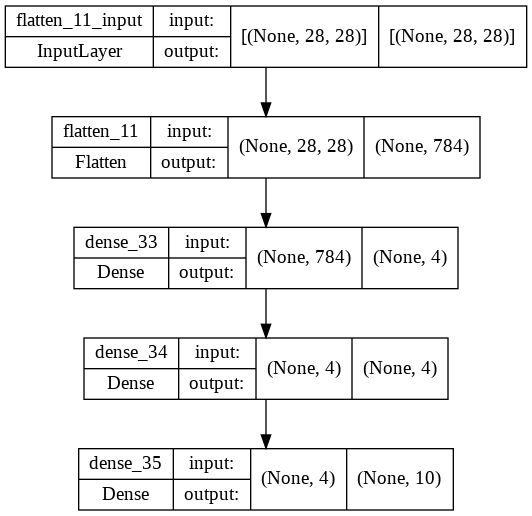

In [ ]:
from tensorflow.keras.utils import plot_model

# See the inputs and outputs of each layer
plot_model(model_14, show_shapes=True)

## How a model learns (in brief)

Alright, we've trained a bunch of models, but we've never really discussed what's going on under the hood. So how exactly does a model learn?

A model learns by updating and improving its weight matrices and biases values every epoch (in our case, when we call the `fit()` fucntion).

It does so by comparing the patterns its learned between the data and labels to the actual labels.

If the current patterns (weight matrices and bias values) don't result in a desirable decrease in the loss function (higher loss means worse predictions), the optimizer tries to steer the model to update its patterns in the right way (using the real labels as a reference).

This process of using the real labels as a reference to improve the model's predictions is called [**backpropagation**](https://en.wikipedia.org/wiki/Backpropagation).

In other words, data and labels pass through a model (**forward pass**) and it attempts to learn the relationship between the data and labels. 

And if this learned relationship isn't close to the actual relationship or it could be improved, the model does so by going back through itself (**backward pass**) and tweaking its weights matrices and bias values to better represent the data.

If all of this sounds confusing (and it's fine if it does, the above is a very succinct description), check out the resources in the extra-curriculum section for more.

## Exercises 🛠

1. Play with neural networks in the [TensorFlow Playground](https://playground.tensorflow.org/) for 10-minutes. Especially try different values of the learning, what happens when you decrease it? What happens when you increase it?
2. Replicate the model pictured in the [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) below using TensorFlow code. Compile it using the Adam optimizer, binary crossentropy loss and accuracy metric. Once it's compiled check a summary of the model.
![tensorflow playground example neural network](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-replication-exercise.png)
*Try this network out for yourself on the [TensorFlow Playground website](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true). Hint: there are 5 hidden layers but the output layer isn't pictured, you'll have to decide what the output layer should be based on the input data.*
3. Create a classification dataset using Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function, visualize it and then build a model to fit it at over 85% accuracy.
4. Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time. Hint: see the [classifcation tutorial in the TensorFlow documentation](https://www.tensorflow.org/tutorials/keras/classification) for ideas.
5. Recreate [TensorFlow's](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) in your own code. Make sure it can accept a tensor and return that tensor after having the softmax function applied to it.
6. Train a model to get 88%+ accuracy on the fashion MNIST test set. Plot a confusion matrix to see the results after.
7. Make a function to show an image of a certain class of the fashion MNIST dataset and make a prediction on it. For example, plot 3 images of the `T-shirt` class with their predictions.



## Extra curriculum 📖
* Watch 3Blue1Brown's neural networks video 2: [*Gradient descent, how neural networks learn*](https://www.youtube.com/watch?v=IHZwWFHWa-w). After you're done, write 100 words about what you've learned.
  * If you haven't already, watch video 1: [*But what is a Neural Network?*](https://youtu.be/aircAruvnKk). Note the activation function they talk about at the end.
* Watch [MIT's introduction to deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) (if you haven't already) to get an idea of the concepts behind using linear and non-linear functions.
* Spend 1-hour reading [Michael Nielsen's Neural Networks and Deep Learning book](http://neuralnetworksanddeeplearning.com/index.html).
* Read the [ML-Glossary documentation on activation functions](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html). Which one is your favourite?
  * After you've read the ML-Glossary, see which activation functions are available in TensorFlow by searching "tensorflow activation functions".